In [109]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from python_tsp.distances import euclidean_distance_matrix
from python_tsp.exact import solve_tsp_dynamic_programming

sns.set(font_scale=1.4, style='whitegrid')

Функции для автоматизации запуска 

In [202]:
def create_input_file(data, method_name):
    """
    :param data:        множество точек, подаваемое на вход алгоритму
    :param method_name: название используемого метода
    """
    # заполняем файл данными:
    # длина набора точек
    os.system(f"echo '{len(data)}' > temp.txt")
    # точки
    for i, point in enumerate(data):
        os.system(f"echo '{i} {point[0]} {point[1]}' >> temp.txt")
    # название метода
    os.system(f"echo '{method_name}' >> temp.txt")

In [203]:
def execute(data, method_name,
            save_time = True,
            save_path = True,
            save_length = True):
    """
    :param data:        множество точек, подаваемое на вход алгоритму
    :param method_name: название используемого метода
    
    сохранять ли
    :param save_time:   время работы алгоритма
    :param save_path:   полученный в результате работы алгоритма путь
    :param save_length: длина полученного в результате работы алгоритма пути
    """
    result = {}
    
    # создаем файл, подающийся на вход
    create_input_file(data, method_name)
    
    # выполняем скрипт
    os.system("./untitled1 < temp.txt > temp2.txt")
    
    # парсим вывод
    with open("temp2.txt", 'r') as output:
        for line in output:
            if line.startswith("Time: ") and save_time:
                time = line[len("Time: "):]
                result["Time"] = float(time.split(" ")[0])
            if line.startswith("Path: ") and save_path:
                path = line[len("Path: "):]
                points = np.array([data[int(idx)] for idx in path.split(" ")[:-1]])
                result["Path"] = points
            if line.startswith("Length: ") and save_length:
                length = line[len("Length: "):]
                result["Length"] = float(length)
    return result

Сравним время работы и точность алгоритмов на различных наборах точек плоскости.

Для этого запустим алгоритмы на данных наборах:

In [ ]:
generate_points = lambda size: np.random.randn(size, 2)

sizes = np.arange(4, 20)
n_samples = 100

christofides_data = pd.DataFrame()
antigreedy_data = pd.DataFrame()

for method_name in ["christofides", "antigreedy"]:
    sizes_column = []
    times_column = []
    lengths_column = []
    for size in sizes:
        for i in range(n_samples):
            np.random.seed(i)
            result = execute(generate_points(size), method_name, save_path = False)
            sizes_column.append(size)
            times_column.append(result["Time"])
            lengths_column.append(result["Length"])
    data = {"size": sizes_column,
            "time": times_column,
            "length": lengths_column }
    if method_name == "christofides":
        christofides_data = pd.DataFrame(data=data)
    else:
        antigreedy_data = pd.DataFrame(data=data)

И посчитаем истинные значения длины оптимального пути:

In [ ]:
sizes = np.arange(4, 16)
n_samples = 100

sizes_column = []
lengths_column = []
for size in sizes:
    for i in range(n_samples):
        np.random.seed(i)
        distance_matrix = euclidean_distance_matrix(generate_points(size))
        permutation, distance = solve_tsp_dynamic_programming(distance_matrix)
        sizes_column.append(size)
        lengths_column.append(distance)
data = {"size": sizes_column,
        "length": lengths_column}
real_data = pd.DataFrame(data=data)

Найдём погрешность:

In [235]:
christofides_part = christofides_data[christofides_data["size"] < 16].copy()
antigreedy_part = antigreedy_data[antigreedy_data["size"] < 16].copy()

christofides_part["real_length"] = real_data["length"]
antigreedy_part["real_length"] = real_data["length"]

christofides_part["mistake"] = (christofides_part["length"] / christofides_part["real_length"] - 1)
antigreedy_part["mistake"] = (antigreedy_part["length"] / antigreedy_part["real_length"] - 1)

chr_stats = christofides_part.groupby(by="size")["mistake"].d escribe()[["mean", "max"]]
antigr_stats = antigreedy_part.groupby(by="size")["mistake"].describe()[["mean", "max"]]

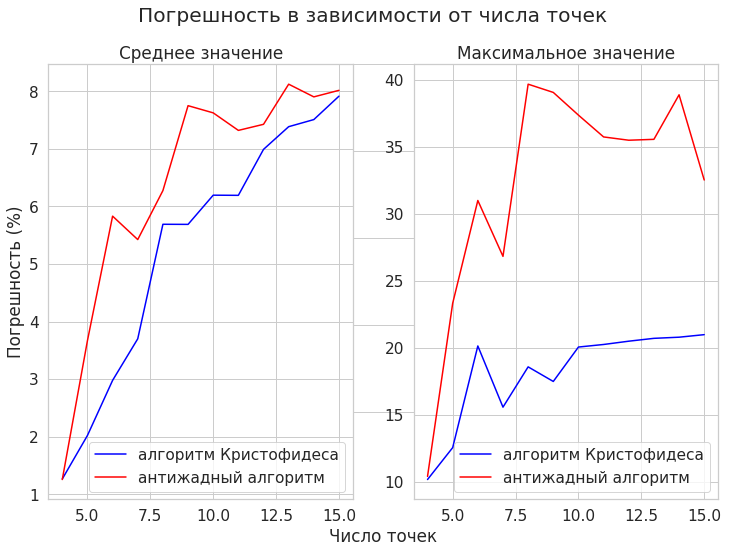

In [236]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Погрешность в зависимости от числа точек')

ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Число точек')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(sizes,
         chr_stats['mean'] * 100,
         color = 'blue',
         label = 'алгоритм Кристофидеса')
ax1.plot(sizes,
         antigr_stats['mean'] * 100,
         color = 'red',
         label = 'антижадный алгоритм')
ax1.set_title("Среднее значение")
ax1.set_ylabel('Погрешность (%)')
ax1.legend()


ax2.plot(sizes,
         chr_stats['max'] * 100,
         color = 'blue',
         label = 'алгоритм Кристофидеса')
ax2.plot(sizes,
         antigr_stats['max'] * 100,
         color = 'red',
         label = 'антижадный алгоритм')
ax2.set_title("Максимальное значение")
ax2.legend()

Найдём среднюю разницу между результатами работы алгоритмов в зависимости от числа точек

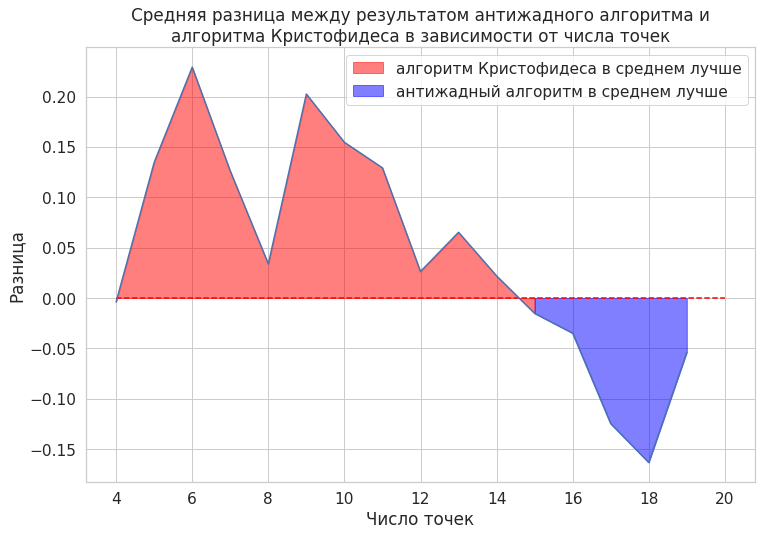

In [272]:
plt.figure(figsize=(12,8))
plt.title('Средняя разница между результатом антижадного алгоритма и' + '\n' +\
          'алгоритма Кристофидеса в зависимости от числа точек')

difference = antigreedy_data[['size', 'length']]
difference['chr_length'] = christofides_data['length']
difference['difference'] = difference['length'] - difference['chr_length']
del difference['length']
del difference['chr_length']
sizes = np.arange(4, 20)
y = difference.groupby(by='size').mean()['difference']
plt.hlines(y=0, 
           xmin = 4,
           xmax = 20,
           color = 'red',
           linestyle = 'dashed')

plt.plot(sizes, y)

plt.fill_between(sizes[:12],
                 y[:12],
                 [0] * 12,
                 color = 'red',
                 alpha = 0.5,
                 label = 'алгоритм Кристофидеса в среднем лучше'
)

plt.fill_between(sizes[11:],
                 y[11:],
                 [0] * 5,
                 color = 'blue',
                 alpha = 0.5,
                 label = 'антижадный алгоритм в среднем лучше'
)

plt.legend()
plt.xlabel('Число точек')
plt.ylabel('Разница')

plt.show()

Сравним время работы алгоритмов в зависимости от числа точек

In [281]:
chr_stats = christofides_data.groupby(by="size")["time"].describe()[["mean", "max", '50%']]
antigr_stats = antigreedy_data.groupby(by="size")["time"].describe()[["mean", "max", '50%']]
sizes = np.arange(4, 20)

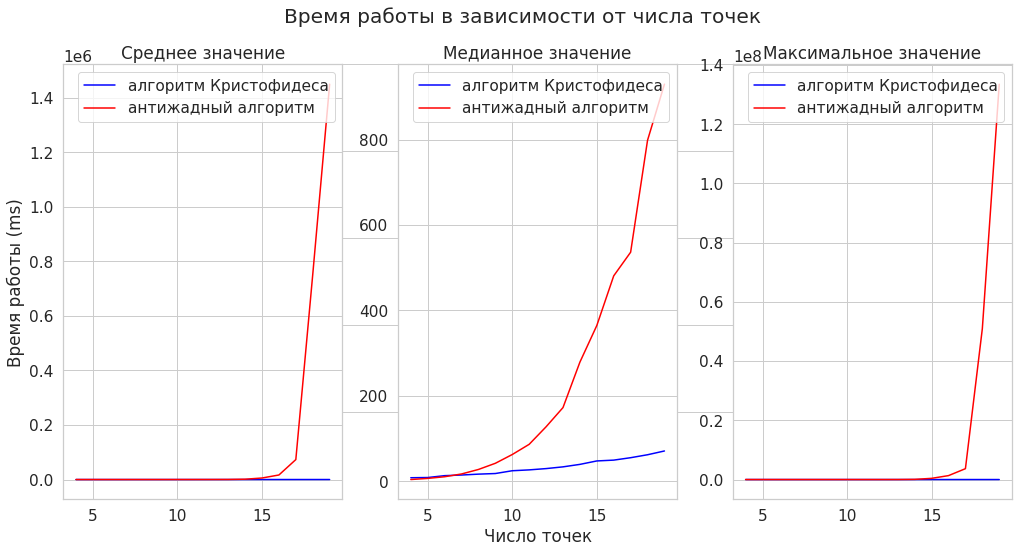

In [285]:
fig = plt.figure(figsize=(17,8))
fig.suptitle('Время работы в зависимости от числа точек')

ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Число точек')

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(sizes,
         chr_stats['mean'] * 100,
         color = 'blue',
         label = 'алгоритм Кристофидеса')
ax1.plot(sizes,
         antigr_stats['mean'] * 100,
         color = 'red',
         label = 'антижадный алгоритм')
ax1.set_title("Среднее значение")
ax1.set_ylabel('Время работы (ms)')
ax1.legend(loc = 'upper right')


ax2.plot(sizes,
         chr_stats['50%'] * 100,
         color = 'blue',
         label = 'алгоритм Кристофидеса')
ax2.plot(sizes,
         antigr_stats['50%'] * 100,
         color = 'red',
         label = 'антижадный алгоритм')
ax2.set_title("Медианное значение")
ax2.legend(loc = 'upper right')

ax3.plot(sizes,
         chr_stats['max'] * 100,
         color = 'blue',
         label = 'алгоритм Кристофидеса')
ax3.plot(sizes,
         antigr_stats['max'] * 100,
         color = 'red',
         label = 'антижадный алгоритм')
ax3.set_title("Максимальное значение")

ax3.legend(loc = 'upper right')

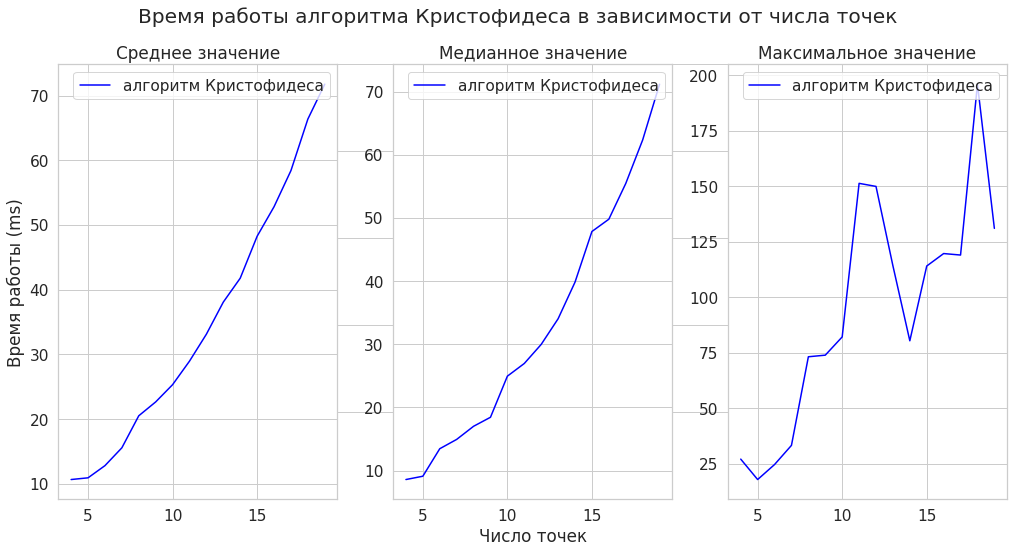

In [286]:
fig = plt.figure(figsize=(17,8))
fig.suptitle('Время работы алгоритма Кристофидеса в зависимости от числа точек')

ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Число точек')

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(sizes,
         chr_stats['mean'] * 100,
         color = 'blue',
         label = 'алгоритм Кристофидеса')
ax1.set_title("Среднее значение")
ax1.set_ylabel('Время работы (ms)')
ax1.legend(loc = 'upper right')


ax2.plot(sizes,
         chr_stats['50%'] * 100,
         color = 'blue',
         label = 'алгоритм Кристофидеса')
ax2.set_title("Медианное значение")
ax2.legend(loc = 'upper right')

ax3.plot(sizes,
         chr_stats['max'] * 100,
         color = 'blue',
         label = 'алгоритм Кристофидеса')
ax3.set_title("Максимальное значение")

ax3.legend(loc = 'upper right')

Пример путей, найденных алгоритмами

Text(0.5, 1.0, 'Оптимальный путь')

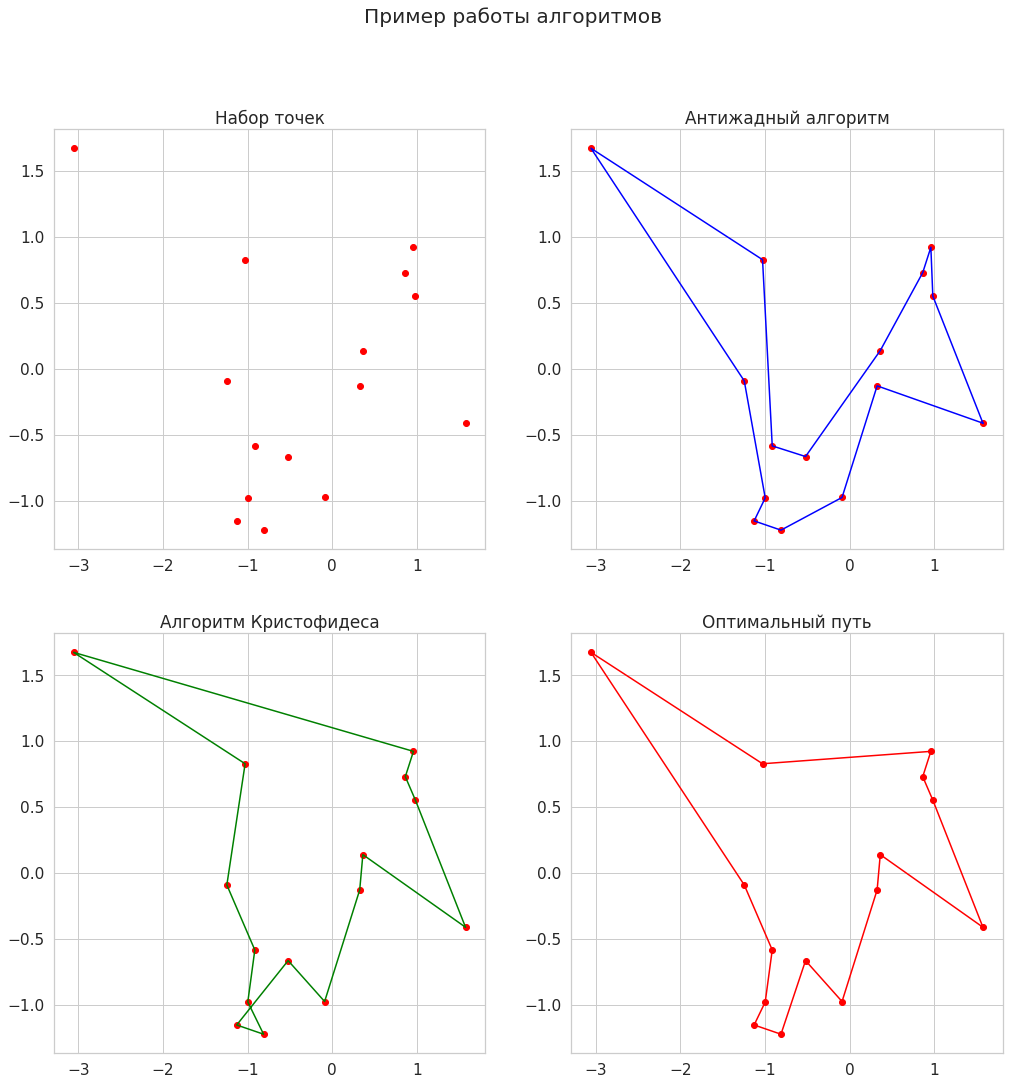

In [318]:
fig = plt.figure(figsize=(17,17))
fig.suptitle('Пример работы алгоритмов')

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

np.random.seed(1703)
sample = generate_points(15)
x, y = sample.T

# набор точек
ax1.scatter(x,
            y, 
            color = 'red')
ax1.set_title('Набор точек')

# результат работы антижадного алгоритма
ax2.scatter(x,
            y, 
            color = 'red')

result = execute(sample, "antigreedy");
antigr_x, antigr_y = result["Path"].T
antigr_x = np.concatenate((antigr_x, antigr_x[:1]))
antigr_y = np.concatenate((antigr_y, antigr_y[:1]))

ax2.plot(antigr_x,
         antigr_y,
         color = 'blue')
ax2.set_title('Антижадный алгоритм')

# результат работы алгоритма Кристофидеса
ax3.scatter(x,
            y, 
            color = 'red')

result = execute(sample, "christofides");
chr_x, chr_y = result["Path"].T
chr_x = np.concatenate((chr_x, chr_x[:1]))
chr_y = np.concatenate((chr_y, chr_y[:1]))

ax3.plot(chr_x,
         chr_y,
         color = 'green')
ax3.set_title("Алгоритм Кристофидеса")

# оптимальный путь
ax4.scatter(x,
            y, 
            color = 'red')

distance_matrix = euclidean_distance_matrix(sample)
permutation, distance = solve_tsp_dynamic_programming(distance_matrix)

opt_x, opt_y = np.array([sample[i] for i in permutation]).T
opt_x = np.concatenate((opt_x, opt_x[:1]))
opt_y = np.concatenate((opt_y, opt_y[:1]))

ax4.plot(opt_x,
         opt_y,
         color = 'red')
ax4.set_title('Оптимальный путь')